In [1]:
from astropy.convolution import Gaussian2DKernel

from utils import *
from modeling import *
from plotting import *

%load_ext autoreload
%autoreload 2

In [2]:
read = False
save = True

## Measurement

mu: 460.20 , std: 4.02 , ZP: 27.10 , pix_scale: 2.50


/home/qliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log10


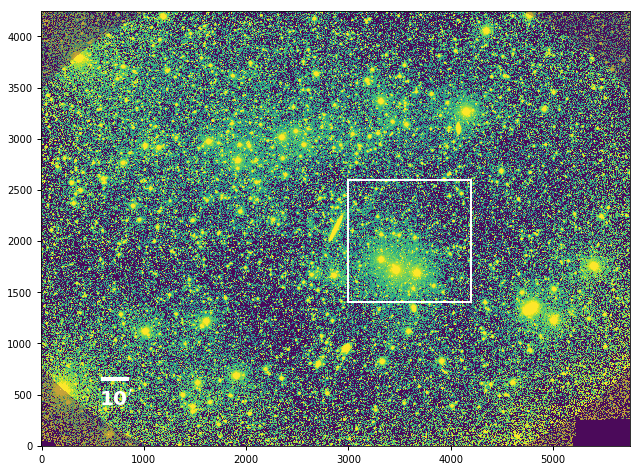

In [4]:
############################################
# Read 
############################################

R_scale = 10
obj_name = 'NGC5907-G'
band = 'G'
 
hdu = fits.open("./data/coadd_Sloan%s_NGC_5907.fits"%band)[0]
data = hdu.data
header = hdu.header
wcs_data = wcs.WCS(header)

seeing = 2.5
# Runned from create_photometric_light_APASS 
seg_map = fits.getdata("./SE_APASS/coadd_Sloan%s_NGC_5907_seg.fits"%band)
seg_map_dilation = seg_map.copy()
for i in range(5):
    seg_map_dilation= morphology.dilation(seg_map_dilation)

weight_edge = fits.getdata("./weight_NGC5907.fits")
SE_cat_full = Table.read("./SE_APASS/coadd_Sloan%s_NGC_5907.cat"%band,
                         format="ascii.sextractor")

mu = np.float(header["BACKVAL"])
ZP, pix_scale = np.float(hdu.header["REFZP"]), np.float(hdu.header["PIXSCALE"])

data_clip = sigma_clip(data[seg_map_dilation==0&(weight_edge>0.5)], sigma=3, maxiters=10)
std = np.std(data_clip) 

print("mu: %.2f , std: %.2f , ZP: %.2f , pix_scale: %.2f" %(mu, std, ZP, pix_scale))

SE_cat_full["RMAG_AUTO"] = -2.5*np.log10(SE_cat_full["FLUX_AUTO"]) + ZP

############################################
# Crop
############################################
# patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = (800, 1800, 1800, 2800)
# patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = (2400, 1500, 3400, 2500)
# patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = (3100, 1400, 4100, 2400)
patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = (3000, 1400, 4200, 2600)
catalog_bounds = (patch_Xmin-50, patch_Ymin-50, patch_Xmax+50, patch_Ymax+50)
image_size = patch_Xmax - patch_Xmin

image_bounds = (patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax)
        
patch, seg_patch = crop_image(data, image_bounds, weight_map=weight_edge, SE_seg_map=seg_map, 
                              sky_mean=mu, sky_std=std, color="w",draw=True)

In [5]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5750                                                  
NAXIS2  =                 4250                                                  
CTYPE1  = 'RA---TAN'                                                            
CRPIX1  =               2875.5                                                  
CRVAL1  =              228.975                                                  
CTYPE2  = 'DEC--TAN'                                                            
CRPIX2  =               2125.5                                                  
CRVAL2  =       56.32916666667                                                  
CD1_1   =  -0.0006944444444444                                                  
CD1_2   =                  0

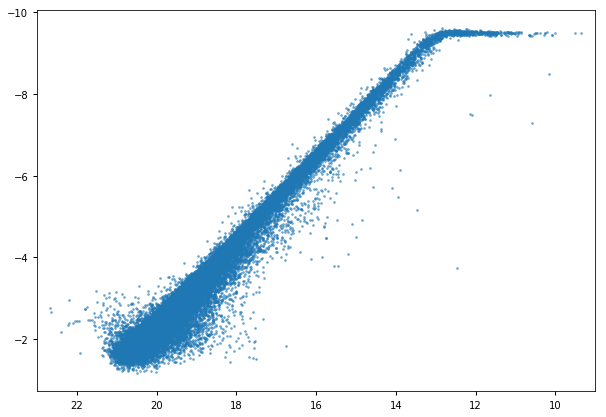

In [4]:
plt.figure(figsize=(10,7))
plt.scatter(SE_cat_full["RMAG_AUTO"], SE_cat_full['MU_MAX'], s=3, alpha=0.5)
plt.xlim(23,9)
plt.gca().invert_yaxis()

In [7]:
# Crossmatch with star catalog
############################################
tab_SE_target, catalog_star = cross_match(header, SE_cat_full, catalog_bounds, radius=2.*u.deg)
tab_SE_target[:10]

Pan-STARRS rmag:  6.675 ~ 23.912


NUMBER,X_IMAGE,Y_IMAGE,ELLIPTICITY,FWHM_IMAGE,FLAGS,RMAG_AUTO,ID_PS,rmag_PS,X_IMAGE_PS,Y_IMAGE_PS
,pix,pix,,pix,,ct,,mag,pix,pix
int64,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64
19063,3466.0796,1721.5258,0.038,7.07,6,10.085963936184577,64764,6.6749,3466.0151,1721.6087
19617,3670.7646,1693.4302,0.124,6.63,6,10.290833322809263,68283,7.9680,3670.3764,1693.3941
18466,3321.3972,1824.0864,0.026,5.57,4,10.63455939990937,64877,8.6055,3321.2541,1824.2012
12025,3936.4358,2605.7576,0.062,3.87,6,11.557654988638834,144159,9.7062,3936.3207,2605.7467
16430,3322.2563,2066.9353,0.099,4.17,4,11.62814986381991,69151,10.2440,3322.3262,2066.843
21048,3634.0322,1540.8929,0.053,3.82,6,11.704921192650467,64144,10.4833,3634.1619,1540.8524
20822,3834.8767,1565.9124,0.084,3.93,4,11.605526253702687,66165,10.4994,3834.8505,1565.9065
21360,3926.0103,1503.4731,0.033,3.36,4,12.071098811450252,66379,10.7379,3925.889,1503.9096


In [8]:
catalog_star

ID_PS,RAJ2000,DEJ2000,objID,Qual,gmag,e_gmag,rmag,e_rmag,X_IMAGE_PS,Y_IMAGE_PS
,deg,deg,,,mag,mag,mag,mag,pix,pix
int64,float64,float64,int64,int16,float64,float32,float64,float32,float64,float64
64764,228.240781110,56.046509330,175252282408376305,128,7.7540,0.0220,6.6749,0.0000,3466.0151,1721.6087
64763,228.241190000,56.046513000,175252282412046577,136,7.5520,--,7.6120,--,3465.6862,1721.6105
68281,227.986660260,56.025634820,175232279866781291,128,8.3534,0.4781,7.7729,0.0010,3670.8289,1694.0989
68283,227.987235000,56.025150000,175232279868030897,136,7.8390,--,7.9680,--,3670.3764,1693.3941
64892,228.418651140,56.118279870,175342284192812589,33,--,--,8.1162,0.0010,3322.1236,1823.6218
68288,227.987288820,56.025334180,175232279873021204,32,--,--,8.3259,0.0088,3670.3293,1693.6587
64876,228.420241660,56.118677670,175342284201873140,160,9.3757,0.1522,8.3525,0.0790,3320.8421,1824.1844
64877,228.419728330,56.118687010,175342284197932877,32,7.9324,0.0010,8.6055,0.0010,3321.2541,1824.2012


In [52]:
c = SkyCoord(catalog_star['RAJ2000'][:50], catalog_star['DEJ2000'][:50], unit=u.deg)
c = SkyCoord([228.420241660,227.987235000], [56.118677670,56.025150000], unit=u.deg)

In [53]:
c_catalog = SkyCoord(catalog_star['RAJ2000'],catalog_star['DEJ2000'], unit=u.deg)

In [59]:
idxc, idxcatalog, d2d, d3d = c_catalog.search_around_sky(c, 5*u.arcsec)

In [62]:
catalog_star[idxcatalog][idxc==0]

ID_PS,RAJ2000,DEJ2000,objID,Qual,gmag,e_gmag,rmag,e_rmag,X_IMAGE_PS,Y_IMAGE_PS
,deg,deg,,,mag,mag,mag,mag,pix,pix
int64,float64,float64,int64,int16,float64,float32,float64,float32,float64,float64
64892,228.418651140,56.118279870,175342284192812589,33,--,--,8.1162,0.0010,3322.1236,1823.6218
64876,228.420241660,56.118677670,175342284201873140,160,9.3757,0.1522,8.3525,0.0790,3320.8421,1824.1844
64877,228.419728330,56.118687010,175342284197932877,32,7.9324,0.0010,8.6055,0.0010,3321.2541,1824.2012
64902,228.418512070,56.118619940,175342284181423074,37,12.8880,0.0010,12.1834,0.0010,3322.2313,1824.1124
64883,228.420172580,56.117820800,175342284202752038,33,--,--,13.4615,0.0010,3320.9075,1822.9509
64894,228.420472800,56.119021150,175342284200283846,33,12.9821,0.0816,13.5730,0.0465,3320.6526,1824.6775
64895,228.419517050,56.117915520,175342284195532221,33,12.8565,0.0402,13.5874,0.0137,3321.4327,1823.0916


In [63]:
catalog_star[idxcatalog][idxc==1]

ID_PS,RAJ2000,DEJ2000,objID,Qual,gmag,e_gmag,rmag,e_rmag,X_IMAGE_PS,Y_IMAGE_PS
,deg,deg,,,mag,mag,mag,mag,pix,pix
int64,float64,float64,int64,int16,float64,float32,float64,float32,float64,float64
68281,227.986660260,56.025634820,175232279866781291,128,8.3534,0.4781,7.7729,0.0010,3670.8289,1694.0989
68283,227.987235000,56.025150000,175232279868030897,136,7.8390,--,7.9680,--,3670.3764,1693.3941
68288,227.987288820,56.025334180,175232279873021204,32,--,--,8.3259,0.0088,3670.3293,1693.6587
68290,227.988238340,56.025698190,175232279886261425,33,13.1425,0.0010,13.3929,0.0010,3669.5577,1694.172
68282,227.988265950,56.025480870,175232279882921176,33,--,--,13.4997,0.0010,3669.54,1693.8587
68284,227.986667050,56.024532670,175232279869410372,33,12.8993,0.0010,13.5991,0.0010,3670.8462,1692.5117
68293,227.986200690,56.026279280,175232279862072264,32,--,--,14.1924,0.0017,3671.1854,1695.0322


In [ ]:
# search around (228.419728330, 56.118687010) and see how these detections compete

In [70]:
np.sqrt(3/0.37)

2.847473987257497

In [78]:
mask_star = fits.getdata("Mask_PS_X%dY%d.fits"%(patch_Xmin, patch_Ymin)).astype(bool)

In [80]:
Sigma[mask_star] = 0

In [96]:
Sigma = np.sqrt(abs(patch-460)/0.37+3**2)

In [97]:
Sigma

array([[3.87550453, 4.47266441, 3.36392361, ..., 4.37460104, 3.84435222,
        3.72556805],
       [3.43869358, 4.03965102, 3.56621323, ..., 3.11930157, 3.15198684,
        3.81122057],
       [3.32224833, 3.26504254, 3.08222527, ..., 3.2546183 , 3.23954553,
        3.13015182],
       ...,
       [4.02559971, 4.21106065, 3.29442819, ..., 4.0436228 , 3.25482621,
        3.53538588],
       [3.78905349, 4.00388461, 4.15478184, ..., 3.08875219, 4.07720107,
        3.57160062],
       [4.87569439, 3.35521926, 3.26750545, ..., 4.29337728, 5.03492037,
        3.97322003]])

In [92]:
np.linalg.inv(Sigma)

369 ms ± 71.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(0, 2.2)

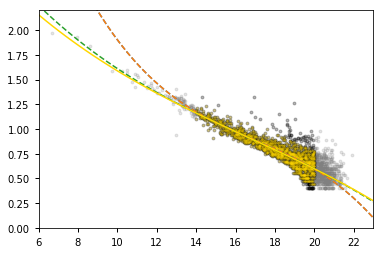

In [6]:
# Read from SE segm map
segm_deblend = SegmentationImage(seg_map)
tab_SE_target['logR'] = np.log10(2*(segm_deblend.get_areas(tab_SE_target["NUMBER"])/np.pi)**0.5)

plt.scatter(tab_SE_target["rmag_PS"], tab_SE_target['logR'], s=8, alpha=0.2, color='gray')

tab = tab_SE_target[(tab_SE_target["rmag_PS"]>14)&(tab_SE_target["rmag_PS"]<20)]

rmag = tab["rmag_PS"]
logR = tab['logR']
p_poly = np.polyfit(rmag, logR, 3)
f_poly = np.poly1d(p_poly)

plt.scatter(rmag, logR, s=8, alpha=0.2, color='k')
mag_ls = np.linspace(6,23)

clip = np.zeros_like(rmag, dtype='bool')
for i in range(3):
    plt.plot(mag_ls, f_poly(mag_ls),ls='--')
    mag, logr = rmag[~clip], logR[~clip]

    p_poly = np.polyfit(mag, logr, 3)
    f_poly = np.poly1d(p_poly)
    
    dev = abs(logR-f_poly(rmag))
    clip = dev>3*np.std(dev)
    
plt.plot(mag_ls, f_poly(mag_ls), color='gold')

plt.scatter(mag, logr, s=3, alpha=0.2, color='gold')
    
plt.xlim(6,23)
plt.ylim(0,2.2)

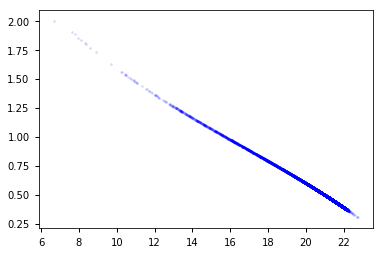

In [7]:
estimate_radius = lambda m: max(10**min(2, f_poly(m)), 2)
rad_est = np.array([estimate_radius(m) for m in catalog_star["rmag"]])
plt.scatter(catalog_star["rmag"], np.log10(rad_est), s=3, alpha=0.1, color='b')

In [81]:
i=0
apers = [CircularAperture((X_c-patch_Xmin, Y_c-patch_Ymin), r=r)
                         for (X_c,Y_c, r) in zip(cat[:]['X_IMAGE_PS'],
                                   cat[:]['Y_IMAGE_PS'], R_est[:])] 

In [84]:
seg_map_catalog = np.zeros((image_size, image_size))
for (k, aper) in enumerate(apers):
    star_ma = aper.to_mask(method='center').to_image((image_size, image_size))
    if star_ma is not None:
        seg_map_catalog[star_ma.astype(bool)] = k+1


In [85]:
mask_star = seg_map_catalog>0

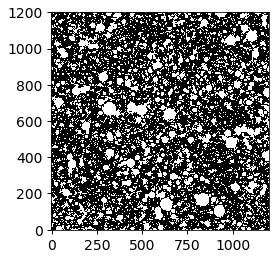

In [86]:
plt.imshow(mask_star)

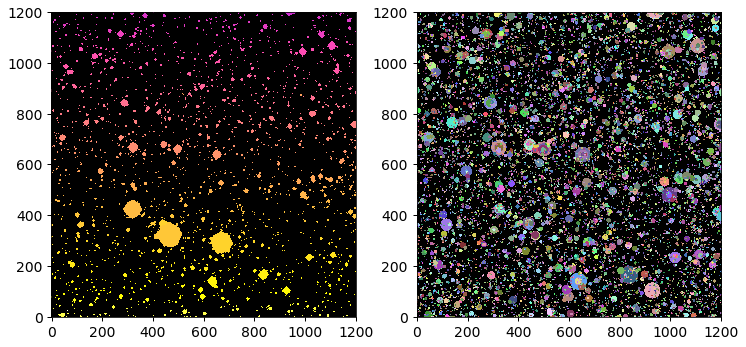

In [88]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.imshow(seg_patch)
ax2.imshow(seg_map_catalog, vmin=1, cmap=make_rand_cmap(10000))

In [57]:
yy, xx = np.mgrid[:image_size,:image_size]
cat = catalog_star[catalog_star['rmag']>10]
R_est = np.array([estimate_radius(m) for m in cat["rmag"]])

In [170]:
mask_stars = [np.logical_or.reduce([np.sqrt((xx-(X-patch_Xmin))**2+(yy-(Y-patch_Ymin))**2) < r
                      for (X,Y, r) in zip(cat[i*200:(i+1)*200]['X_IMAGE_PS'],
                                          cat[i*200:(i+1)*200]['Y_IMAGE_PS'], R_est[i*200:(i+1)*200])])
              for i in range(58)]

920770


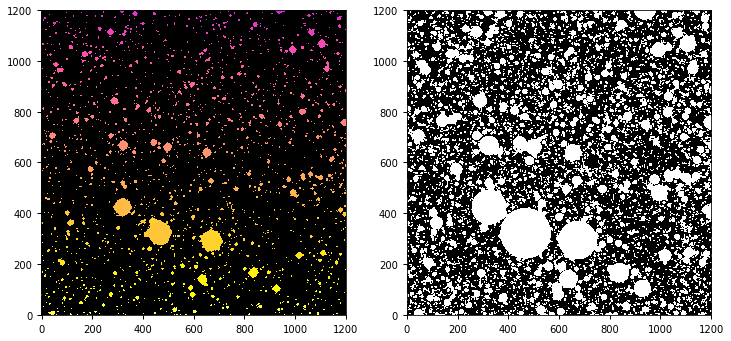

In [172]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.imshow(seg_patch)
mask_star = np.logical_or.reduce(mask_stars)
ax2.imshow(mask_star)
print(np.sum(~mask_star))

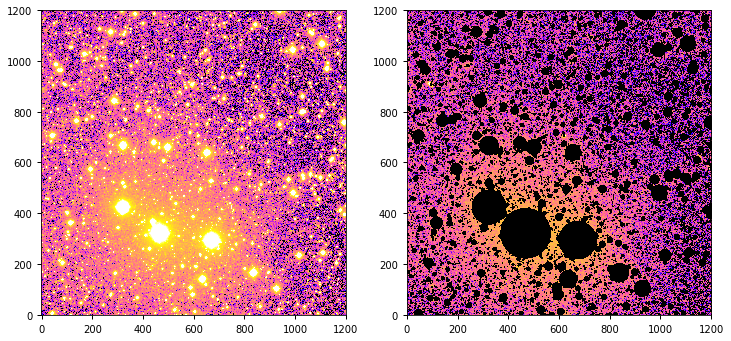

In [176]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.imshow(patch, vmin=mu-2, vmax=mu+50, norm=norm1)
patch2=patch.copy()
patch2[mask_star] = 0
ax2.imshow(patch2, vmin=mu-2, vmax=mu+50, norm=norm1)

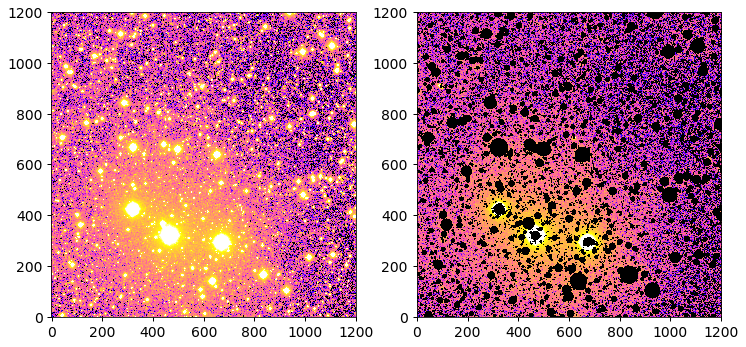

In [89]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.imshow(patch, vmin=mu-2, vmax=mu+50, norm=norm1)
patch2=patch.copy()
patch2[mask_star] = 0
ax2.imshow(patch2, vmin=mu-2, vmax=mu+50, norm=norm1)

In [ ]:
# Duplicate star? Do a auto-correlation of PANSTARRS catalog

In [183]:
hdu = fits.PrimaryHDU(mask_star.astype(float))
hdu.writeto("Mask_PS_X%dY%d.fits" %(patch_Xmin, patch_Ymin))

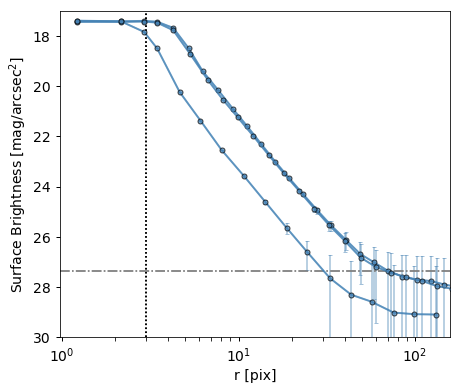

In [143]:
plt.figure(figsize=(7,6))

for num in [24056, 22851, 25585]:
    id = num-1
    img_thumb, star_ma, star_bkg, cen_star = extract_star(id, SE_cat_full, wcs_data, data, seg_map,
                                                        n_win=40, sn_thre=3, display_bg=False, display=False, verbose=False)

    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_thumb, cen=cen_star, mask=star_ma, 
                                                 ZP=ZP, sky_mean=mu, sky_std=std,
                                                 xunit="pix", yunit="SB",
                                                  scatter=False, errorbar=True, plot_line=True)
    
plt.xscale("log")

In [214]:
obj = tab_SE_target
d_cens=np.array([obj['X_IMAGE_PS']-obj['X_IMAGE'], obj['Y_IMAGE_PS']-obj['Y_IMAGE']])


In [215]:
tab_SE_target[np.argsort((d_cens**2).sum(axis=0))][-20:]

NUMBER,X_IMAGE,Y_IMAGE,ELLIPTICITY,FWHM_IMAGE,FLAGS,RMAG_AUTO,ID_PS,rmag_PS,X_IMAGE_PS,Y_IMAGE_PS,logR
,pix,pix,,pix,,ct,,mag,pix,pix,
int64,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64
16409,3179.5518,2088.2393,0.588,5.98,0,20.19488838409917,73501,20.3547,3179.4854,2086.9261,0.6094267354703327
16309,3542.8506,2102.0901,0.532,7.07,1,19.169550832062548,69458,20.8555,3543.8398,2102.9815,0.7681369413964079
12052,3398.0374,2622.22,0.45,6.01,0,18.80224496909609,79416,19.7614,3396.7945,2622.7079,0.8181945178380419
19133,3663.2207,1781.3741,0.585,6.42,0,19.826824885561848,68438,19.4152,3662.3065,1782.391,0.6545150506448767
15410,4025.5137,2196.9683,0.368,6.23,0,13.135266273151238,142945,12.9944,4024.4583,2196.0952,1.4079366188145521
13838,3713.3538,2404.0139,0.475,6.78,0,19.467631084130836,71092,20.5454,3713.9029,2405.2978,0.8117120292558581
20409,3812.0286,1632.2988,0.361,5.65,0,17.42041862341053,68480,18.1807,3813.3829,1631.8844,0.934169056098383
21365,3317.4395,1514.4579,0.474,6.54,0,16.876176333096552,64361,16.8868,3316.2829,1513.6262,0.9841164893771422


NUMBER:  19617
X_c, Y_c:  (3670.7646, 1693.4302)
RA, DEC:  (227.98675202, 56.025171198)
x_min, x_max, y_min, y_max:  1427 1957 3405 3935
X_min, X_max, Y_min, Y_max:  3405.7646 3935.7646 1428.4302 1958.4302


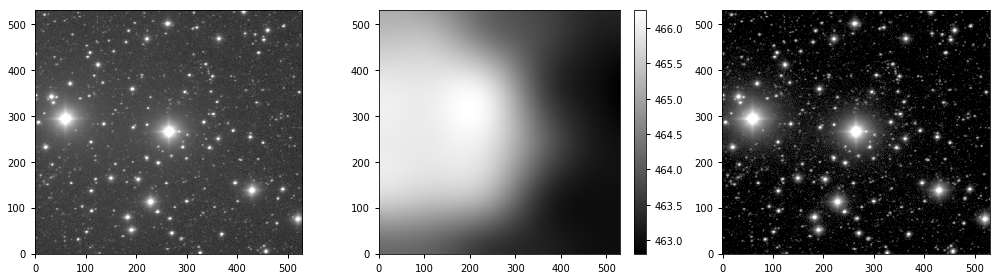

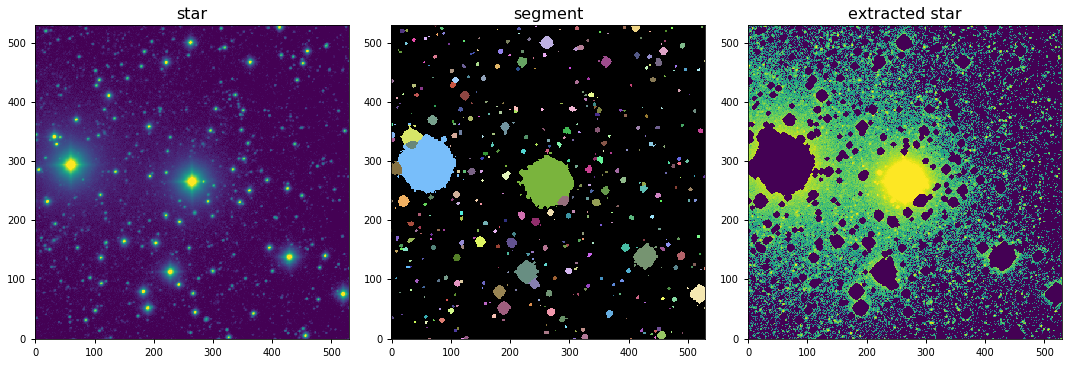

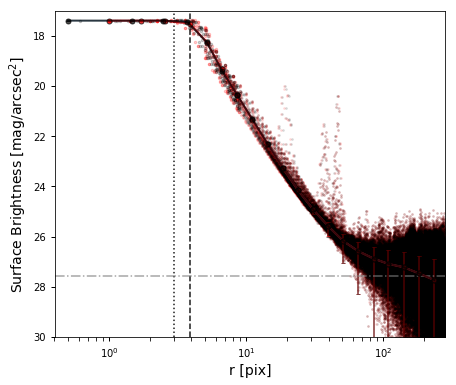

In [31]:
num = 19617
id = num-1
img_thumb, star_ma, star_bkg, cen_star = extract_star(id, SE_cat_full, wcs_data, data, seg_map,
                                                      n_win=40, sn_thre=3, display_bg=True, display=True, verbose=True)

obj = tab_SE_target[tab_SE_target['NUMBER']==num]

plt.figure(figsize=(7,6))
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_thumb, cen=cen_star, mask=star_ma, 
                                             ZP=ZP, sky_mean=mu, sky_std=std,
                                             xunit="pix", yunit="SB", color="r",
                                              scatter=True, errorbar=True, plot_line=True)

d_cen=np.array([obj['X_IMAGE_PS']-obj['X_IMAGE'], obj['Y_IMAGE_PS']-obj['Y_IMAGE']]).ravel()
cen_star_PS = cen_star + d_cen
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_thumb, cen=cen_star_PS, mask=star_ma, 
                                              ZP=ZP, sky_mean=mu, sky_std=std,
                                              xunit="pix", yunit="SB", color="k",
                                              scatter=True, errorbar=True, plot_line=False)

plt.xscale("log")

In [55]:
if read:
    table_res_Rnorm = Table.read("./%s-Rnorm_%dpix_15mag_X%dY%d.txt"\
                                 %(obj_name, R_scale, patch_Xmin, patch_Ymin), format="ascii")
    table_res_Rnorm = crop_catalog(table_res_Rnorm, bounds=image_bounds)

else:
    res_Rnorm, res_thumb = compute_Rnorm_batch(tab_SE_target, SE_cat_full, wcs_data, data, seg_map, 
                                               R=R_scale, wid=0.5, return_full=True)

    table_res_Rnorm = Table(np.hstack([np.array(tab_SE_target['NUMBER'])[:, None],
                                       np.array(tab_SE_target['X_IMAGE'])[:, None],
                                       np.array(tab_SE_target['Y_IMAGE'])[:, None], res_Rnorm]),
                            names=['NUMBER','X_IMAGE','Y_IMAGE','mean','med','std','sky'], dtype=['int']+['float']*6)
    if save:
        save_thumbs(res_thumb, '%s-Thumb_15mag_X%sY%s'%(obj_name, patch_Xmin, patch_Ymin))
        table_res_Rnorm.write('%s-Rnorm_%dpix_15mag_X%sY%s.txt'\
                              %(obj_name, R_scale, patch_Xmin, patch_Ymin), overwrite=True, format='ascii')

completed: 39/197
completed: 78/197
completed: 117/197
completed: 156/197
completed: 195/197
Save thumbs to: NGC5907-R-Thumb_15mag_X3100Y1400


## Plotting

/home/qliu/Desktop/PSF/utils.py:61: RuntimeWarning: divide by zero encountered in log10
  I_SB = -2.5*np.log10(y - BKG) + ZP + 2.5 * np.log10(pix_scale**2)
/home/qliu/Desktop/PSF/utils.py:61: RuntimeWarning: invalid value encountered in log10
  I_SB = -2.5*np.log10(y - BKG) + ZP + 2.5 * np.log10(pix_scale**2)
/home/qliu/Desktop/PSF/utils.py:61: RuntimeWarning: invalid value encountered in log10
  I_SB = -2.5*np.log10(y - BKG) + ZP + 2.5 * np.log10(pix_scale**2)


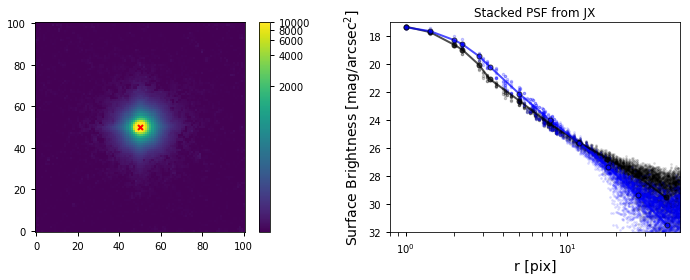

In [12]:
hdu = fits.open("./med_psf_JX.fits")[0]
hdu_p = fits.open("./median_psf_patch.fits")[0]
PSF_JX = hdu.data * 10 + mu
PSF_JX_p = hdu_p.data * 1e5 + mu

fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
im = ax1.imshow(PSF_JX_p, vmin=mu, vmax=10000, norm=norm1, aspect="equal", origin="lower", cmap="viridis")
ax1.plot(50,50,"rx",ms=5,mew=2)
colorbar(im)

ax2 = plt.subplot(122)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX, cen=(50,50),
                                             ZP=ZP, sky_mean=mu, sky_std=1, pix_scale=pix_scale,
                                             xunit="pix", yunit="SB", color="k",
                                             scatter=True, core_undersample=True)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX_p, cen=(50,50),
                                             ZP=ZP, sky_mean=mu, sky_std=1, pix_scale=pix_scale,
                                             xunit="pix", yunit="SB", color="b",
                                             scatter=True, core_undersample=True)
plt.ylim(32,17)
plt.title("Stacked PSF from JX")
plt.tight_layout()

In [11]:
import random
colour = [ "indianred", "steelblue", "seagreen", "gold", "lightcyan", "orchid", "orange", "gray", "brown" ]
random.seed(88)
rand_colours = [random.choice(colour) for i in range(len(tab_SE_target))]

psf = PSF_Model(params={"fwhm":2.28*pix_scale, "beta":10, 'theta_0':5},
                aureole_model='power', pixel_scale=2.5)

In [56]:
def plot_PSF(fit_res, res_thumb, tab_target, 
             r_core=12, pixel_scale=pix_scale, mag_name='rmag_PS',
             plot_stars=True, plot_stack=None, color='r', **kwargs):
    r = np.logspace(0.03,2.5,100)
    pmed, pmean, pcov = get_params_fit(fit_res1)    
    I_tot_A, I_tot_B, I_tot_C = plot_fit_res_SB(pmed, psf, r=r, **kwargs)
    mu_fit, std_fit = pmed[-2], pmed[-1]
    mu = 884
    
    z_mean_s, z_med_s = table_res_Rnorm['mean'],table_res_Rnorm['med'] 
    z_std_s, sky_mean_s = table_res_Rnorm['std'],table_res_Rnorm['sky']

    plt.figure(figsize=(10,8))
    for num, rmag, sky_m, c in zip(tab_target["NUMBER"], tab_target[mag_name], sky_mean_s, rand_colours):
        img, ma, cen = res_thumb[num]['image'], res_thumb[num]['mask'], res_thumb[num]['center']
        alpha = min(0.1*(16-rmag), 0.7) 
        errorbar = True if rmag<10 else False
        r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img, cen=cen, mask=ma, 
                                                      ZP=ZP, sky_mean=mu, sky_std=std_fit, dr=1.5,
                                                      xunit="pix", yunit="SB", errorbar=errorbar,
                                                      color=c, lw=1, alpha=alpha)

    plt.fill_betweenx([32, 16.], x1=R_scale-0.5, x2=R_scale+0.5, color="gold", alpha=0.3)
    
    if plot_stars:
        for z_m, z_std, sky_m, c in zip(z_mean_s, z_std_s, sky_mean_s, rand_colours):
            plt.plot(R_scale, Intensity2SB(z_m, sky_m, ZP, pixel_scale),"*", ms=10, color=c, alpha=0.5, zorder=3)
            
    if plot_stack is not None:
        r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(plot_stack, cen=(50,50), mask=None,
                                                      ZP=ZP, sky_mean=mu, sky_std=std_fit,
                                                      pix_scale=pixel_scale, dr=1,
                                                      xunit="pix", yunit="SB", color="k",
                                                      lw=4, label="Stacked PSF (JX)",
                                                      core_undersample=True, plot_line=False)
    for k, I in enumerate([I_tot_C, I_tot_B, I_tot_A]):
        lab = "Fit (1D profile)" if k==0 else None
        plt.plot(r[r>12], I[r>12], color=color, ls="--", lw=3, label=lab, zorder=3, alpha=0.9)
    plt.axvspan(12, 24, color="steelblue",  alpha=0.1)
    plt.axvspan(24, 65, color="seagreen", alpha=0.1)
    plt.axvspan(0.8, 12, color="gray", alpha=0.2, label="Mask")
    plt.axhline(mu)
    plt.legend(fontsize=14)
    plt.ylim(32,17.)
    plt.xlim(1,220)

### Patch [800, 1800, 800, 2800] stars < 15 mag

In [26]:
fit_res1 = open_nested_fitting_result(filename='./real/fit_real_best_X800Y1800.res')
res_thumb1 = load_thumbs('%s-Thumb_15mag_X800Y1800'%obj_name)

In [27]:
plot_PSF(fit_res1, res_thumb1)

### R-band Patch [3100, 1400, 4100, 2400]  containing brighter stars

In [57]:
fit_res1 = open_nested_fitting_result(filename='./real/fit_real_best_X3100Y1400.res')
res_thumb1 = load_thumbs('%s-Thumb_15mag_X3100Y1400'%obj_name)

Read thumbs from: NGC5907-R-Thumb_15mag_X3100Y1400


Fit results:  [-6.50509899e-01  3.37575963e+00  8.86088255e+02  2.99074134e+00]


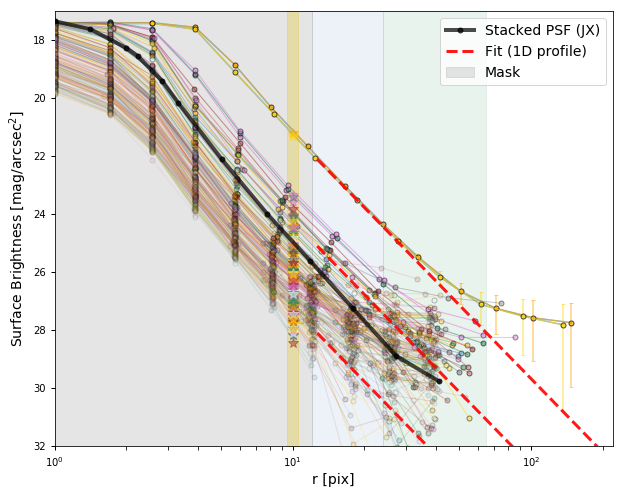

In [58]:
plot_PSF(fit_res1, res_thumb1, tab_SE_target,
         plot_stack=PSF_JX_p, mags=[14, 11, 8], ZP=ZP)

Fit results:  [-6.50495723e-01  3.37575243e+00  8.86088254e+02  2.99072081e+00]


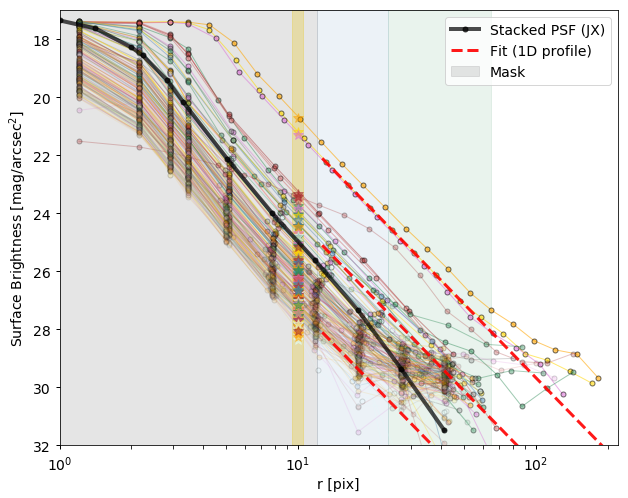

In [39]:
plot_PSF(fit_res1, res_thumb1, plot_stack=PSF_JX_p, mags=[14, 11, 8])

### G-band Patch [3100, 1400, 4100, 2400]  containing brighter stars

Read thumbs from: NGC5907-G-Thumb_15mag_X3100Y1400
Fit results:  [ -0.97171082   3.28641483 462.88711497   5.13372273]


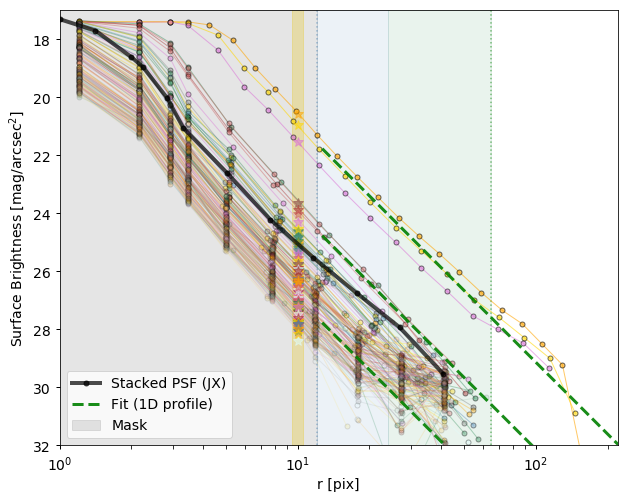

In [54]:
fit_res2 = open_nested_fitting_result(filename='NGC5907-G-fit_best_X3100Y1400.res')
fit_res2 = open_nested_fitting_result(filename='./NGC5907-G-fit_best_X3100Y1400.res')
res_thumb2 = load_thumbs('NGC5907-G-Thumb_15mag_X3100Y1400')
plot_PSF(fit_res2, res_thumb2,  plot_stack=PSF_JX, color='g', mags=[13,10,7])
plt.axvline(65, color="g", ls=":", alpha=0.5)
plt.axvline(12, color="steelblue", ls=":", alpha=0.5)

### Another patch [800, 600, 1800, 1600]  containing brighter stars (the same fit)

In [104]:
fit_res2 = open_nested_fitting_result(filename='./real/fit_real_best_X800Y600.res')

Fit results:  [-7.53674241e-01  3.37092177e+00  8.86120569e+02  3.44800822e+00]
